# Maximum Likelihood Estimation (MLE) for Linear Regression 

First import the necessary modules and configurations:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.optimize import minimize
from scipy.stats import norm

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Generate Synthetic Training Dataset

Generate a training dataset, $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)}) \}_{i=1}^N$, with $N$ examples of input $\mathbf{x} \in \mathbb{R}^n$ and output $y \in \mathbb{R}$ pairs and assume a linear regression model as we did in the [Batch GD example](https://github.com/mazrk7/EECE5644_IntroMLPR_LectureCode_Summer1/blob/main/notebooks/ls_regression_batch_gd.ipynb):

\begin{equation*}
\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \boldsymbol{\epsilon}
\end{equation*}

Where $\mathbf{y} \in \mathbb{R}^N$ is the target vector, $\mathbf{X} \in \mathbb{R}^{N \times (n+1)}$ the <b>design matrix</b> and $\boldsymbol{\epsilon} \in \mathbb{R}^N$ is the vector of error terms.

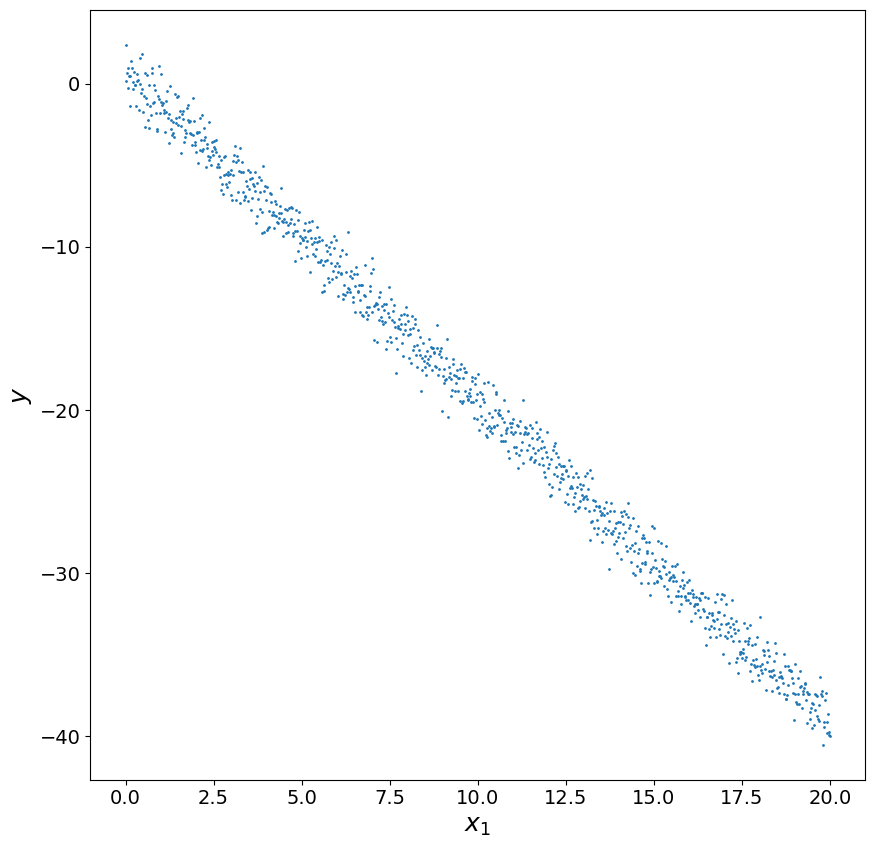

In [2]:
# Generating synthetic data

# Number of input samples to provide to algorithm
N = 1000

X = np.linspace(0, 20, N) # N evenly spread values in the range [0, 20]
X = np.column_stack((np.ones(N), X))  # Prepend column of ones to create augmented inputs x tilde

theta_true = np.array([0.7, -2]) # True parameter vector of bias w_0 and regression slope w_1

# y = X*theta_true + noise
y = X.dot(theta_true) + np.random.normal(0, 1, N)

plt.ioff() # These are Jupyter only lines to avoid showing the figure when I don't want
fig, ax_scatter = plt.subplots(figsize=(10, 10))
ax_scatter.scatter(X[:, 1], y, s=1)
ax_scatter.set_xlabel(r"$x_1$")
ax_scatter.set_ylabel(r"$y$")

display(fig) # Display as .png

fig;

## Least Squares Regression Model

Gentle reminder that for least squares linear regression, our loss function $\mathcal{L}_\text{RSS}(\boldsymbol{\theta})$ is the RSS error:

\begin{equation*}
\mathcal{L}_\text{RSS}(\boldsymbol{\theta}) = \sum_{i=1}^N (\hat{y}^{(i)} - y^{(i)})^2 = \sum_{i=1}^N (\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})^2
\end{equation*}

Which can also be written equivalently as a matrix expression:

\begin{equation*}
(\mathbf{X}\boldsymbol{\theta} - \mathbf{y})^\intercal (\mathbf{X}\boldsymbol{\theta} - \mathbf{y})
\end{equation*}

This has been looked at previously <b>without</b> a probabilistic interpretation in previous notebooks applying GD: [Batch GD example](ls_regression_batch_gd.ipynb) and [SGD example](ls_regression_stochastic_gd.ipynb).

Below is the analytical solution to this model: 

\begin{equation*}
\boldsymbol{\theta}_{opt} = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^\intercal \mathbf{y}
\end{equation*}

As well as the Mean Squared Error (MSE) loss function $\mathcal{L}_\text{MSE}(\boldsymbol{\theta})$, which is typically viewed as the RSS above scaled by $\frac{1}{N}$ (i.e. taking the average):

$$\mathcal{L}_\text{MSE}(\boldsymbol{\theta}) = \frac{1}{N}\mathcal{L}_\text{RSS}(\boldsymbol{\theta}).$$

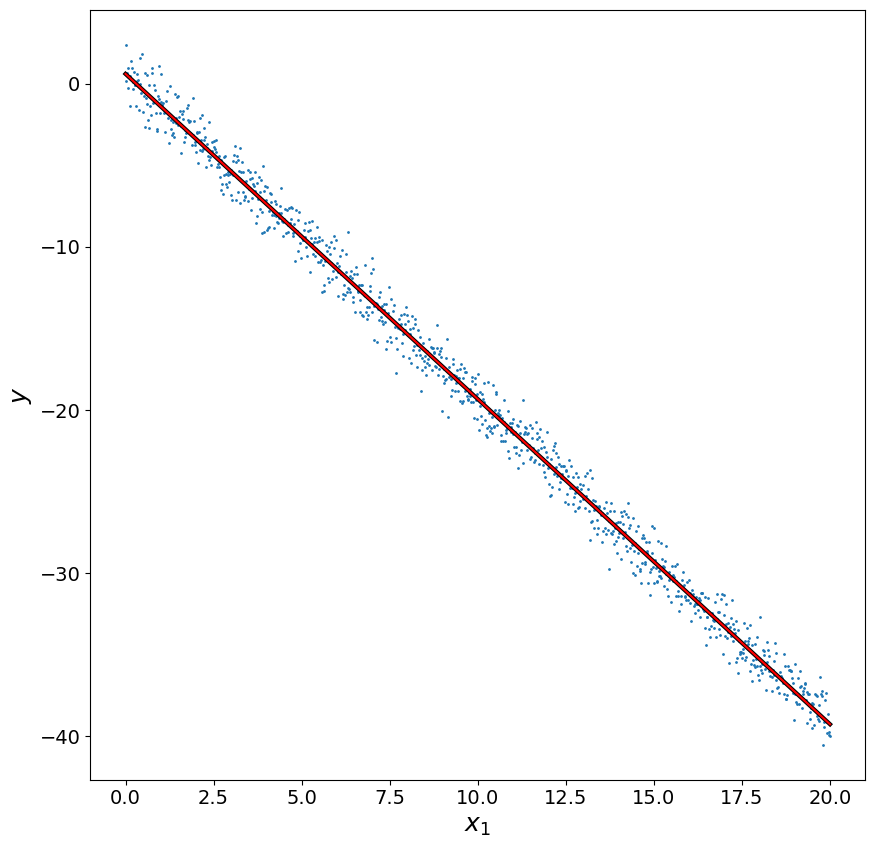

In [3]:
def analytical_solution(X, y):
    # Analytical solution is (X^T*X)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

theta_opt = analytical_solution(X, y)
analytical_preds = X.dot(theta_opt)

# Plot the OLS regression line on our original scatter plot
ax_scatter.plot(X[:, 1], analytical_preds, color='k', linewidth=3, label="OPT")

# Mean Squared Error (MSE) loss
def lin_reg_loss(theta, X, y):
    # Linear regression model X * theta
    predictions = X.dot(theta)
    # Residual error (X * theta) - y
    error = predictions - y
    # Loss function is MSE
    loss_f = np.mean(error**2)

    return loss_f

# Need to provide a function handle to the optimizer, which returns the loss objective, e.g. MSE
def func_mse(theta):
    return lin_reg_loss(theta, X, y)

theta0 = np.random.randn(X.shape[1]) # Random initialization

# Minimize using a default unconstrained minimization optimization algorithm
mse_model = minimize(func_mse, theta0, tol=1e-6)
# res is the optimization result, has an .x property which is the solution array, e.g. theta*

# Predictions with our optimized theta
mse_preds = X.dot(mse_model.x)

# Plot the learned regression line on our original scatter plot
ax_scatter.plot(X[:, 1], mse_preds, color='red', label="MSE")

display(fig) # Display as .png
fig;

## Maximum Likelihood Estimation (MLE)

In maximum likelihood parameter estimation, our goal is to estimate the parameter $\hat{\boldsymbol{\theta}}_{\text{MLE}}$ from a particular parametrized family that maximizes the likelihood of seeing a given dataset $\mathcal{D} = \{\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)}\}$. Formally, this is written as:

$$ \begin{align}
\hat{\boldsymbol{\theta}}_{\text{MLE}} = \mathop{\rm argmax}_{\boldsymbol{\theta}} \text{LL}(\boldsymbol{\theta}) & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \log p(\mathcal{D} \, | \, \boldsymbol{\theta}) \\ & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \sum_{i=1}^N \log p(\mathbf{x}^{(i)} \, | \, \boldsymbol{\theta}),
\end{align}$$

where $\text{LL}(\boldsymbol{\theta}) = \log p(\mathcal{D} \, | \, \boldsymbol{\theta})$ is the log-likelihood function of the data $\mathbf{x}^{(i)}$ contained in dataset $\mathcal{D}$ (the natural log of the likelihood function is taken because it does not change where the maximum occurs and is generally beneficial for analysis, e.g., removes exponents in Gaussian pdfs).

<b>Side-note on Maximum a Posteriori (MAP) estimation:</b> same idea as MLE, where MAP parameter estimation also aims to determine the optimal weights/parameters for a model given a dataset $\mathcal{D}$. The MAP parameter estimate $\hat{\boldsymbol{\theta}}_{\text{MAP}}$ for an arbitrary model is given by:

$$ \begin{align}
\hat{\boldsymbol{\theta}}_{\text{MAP}} & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \log p(\boldsymbol{\theta}\, | \,\mathcal{D}) \\
& = \mathop{\rm argmax}_{\boldsymbol{\theta}} \log p(\mathcal{D}\, | \,\boldsymbol{\theta}) + \log p(\boldsymbol{\theta}),
\end{align}$$

which is equivalent to MLE when the prior $p(\boldsymbol{\theta})$ is uniform as $p(\boldsymbol{\theta}) \propto 1$, ergo $\hat{\boldsymbol{\theta}}_{\text{MLE}} = \hat{\boldsymbol{\theta}}_{\text{MAP}}$. 

### MLE for Linear Regression

Please follow through my notes on this derivation for linear regression, but basically we are now performing parameter estimation for the <b>conditional</b> model $p(y \, | \, \mathbf{x}; \boldsymbol{\theta})$. Recall that the model parameters $\boldsymbol{\theta}$ for linear regression are the coefficients/weights and bias term $\boldsymbol{\theta} = [w_0, \mathbf{w}]$. In linear regression, we model the problem as a Gaussian $p(y \, | \, \mathbf{x}; \boldsymbol{\theta}) = \mathcal{N}\big(y \, | \, \mathbf{w}^\intercal \mathbf{\tilde{x}}, \sigma^2 \big)$, where $\mathbf{w}^\intercal \mathbf{\tilde{x}}$ are a linear combination of inputs with weights (including the bias) to capture the mean of the distribution, and $\sigma^2$ is a variance measure (for simplicity, often fixed) of error/noise in the data.

Let us now consider a <b>labelled</b> dataset $\mathcal{D} = \{(\mathbf{x}^{(1)}, y^{(1)}), \ldots, (\mathbf{x}^{(N)}, y^{(N)})\}$, the resulting maximum likelihood parameter estimate $\hat{\boldsymbol{\theta}}_{\text{MLE}}$ for linear regression given $\mathcal{D}$ can be found by solving the optimization problem:

$$ \begin{align}
\hat{\boldsymbol{\theta}}_{\rm MLE} = \mathop{\rm argmax}_{\boldsymbol{\theta}} \text{LL}(\boldsymbol{\theta}) & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \log p(\mathcal{D} \, | \, \boldsymbol{\theta}) \\ 
& = \mathop{\rm argmax}_{\boldsymbol{\theta}} \sum_{i=1}^N \log p(y^{(i)} \, | \,\mathbf{\tilde{x}}^{(i)}; \boldsymbol{\theta}) \\
&=  \mathop{\rm argmax}_{\boldsymbol{\theta}} -\left(\frac{1}{2\sigma^2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2 + \frac{N}{2}\log(2\pi \sigma^2)\right),
\end{align} $$

where both $\boldsymbol{\mu}=\mathbf{w}^\intercal \mathbf{\tilde{x}}$ and $\sigma^2$ make up the parameters $\boldsymbol{\theta} = [\boldsymbol{\mu}, \sigma^2]$. This optimization problem can be derived by taking the natural log of the Gaussian pdf and dropping terms that do not depend on $\mathbf{w}^\intercal \mathbf{\tilde{x}}$ or $\sigma$. Moreover, note that if I assume $\sigma^2 = 1$, then I can remove the second term above and simplify the maximization problem to:

$$
\hat{\boldsymbol{\theta}}_{\rm MLE} = \mathop{\rm argmax}_{\boldsymbol{\theta}} \text{LL}(\boldsymbol{\theta}) = -\left(\frac{1}{2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2 \right),
$$

Finally, as most of machine learning frames optimization problems as minimizations (minimizing cost, risk, loss etc.) and if we are to tackle this problem using GD, the let's simply re-define the above maximization of log-likelihood to find $\hat{\boldsymbol{\theta}}_{\text{MLE}}$ as instead minimizing the negative log-likelihood (NLL):

$$ \begin{align}
\hat{\boldsymbol{\theta}}_{\rm MLE} = \mathop{\rm argmax}_{\boldsymbol{\theta}} \text{LL}(\boldsymbol{\theta}) = \mathop{\rm argmin}_{\boldsymbol{\theta}} -\text{LL}(\boldsymbol{\theta}) & = \mathop{\rm argmin}_{\boldsymbol{\theta}} \text{NLL}(\boldsymbol{\theta}) \\ & = \mathop{\rm argmin}_{\boldsymbol{\theta}}\frac{1}{2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2.
\end{align}$$

Which if we revert back to the previous notation for our linear regression model using $\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}} = \mathbf{w}^\intercal \mathbf{\tilde{x}}$ realise looks awfully like our original RSS loss function $\mathcal{L}_{RSS}(\boldsymbol{\theta})$ (plus a negligible constant in the optimization $\frac{1}{2}$). The $\boldsymbol{\theta}$ in the previous framework instead of $\mathbf{w}$ is again just to delineate between arbitrary parameters of a distribution, e.g. $\theta=[\mu,\sigma]$, and the regression coefficients/weights $\mathbf{w}$.

So the code below computes the $\text{NLL}(\boldsymbol{\theta})$ loss function to find the optimal parameter estimates  $\hat{\boldsymbol{\theta}}_{\text{MLE}}$ (mean of our conditional Gaussian for linear regression with a fixed noise parameter), however remember we need to optimize and therefore take the derivative and set $\nabla\text{NLL}_{\mathbf{w}}(\boldsymbol{\theta})=0$. For $\text{NLL}(\boldsymbol{\theta})$ in linear regression, the derivative taken with respect to our only parameters, the weights $\mathbf{w}$, is:

\begin{equation*}
\nabla\text{NLL}_{\mathbf{w}}(\boldsymbol{\theta}) = \sum_{i=1}^N (\mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})\mathbf{\tilde{x}}^{(i)}
\end{equation*}

Which in matrix form is:

\begin{equation*}
\nabla\text{NLL}_{\mathbf{w}}(\boldsymbol{\theta}) = \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - \mathbf{X}^\intercal\mathbf{y}
\end{equation*}

Therefore the optimal solution by setting to zero and taking the inverse is:

\begin{equation*}
\mathbf{w}^* = (\mathbf{X}^\intercal \mathbf{X})^{-1}\mathbf{X}^\intercal\mathbf{y}
\end{equation*}

With $\mathbf{w}^*$ as your optimal regression coefficients, a.k.a. your optimal ML parameter estimates  $\hat{\boldsymbol{\theta}}_{\text{MLE}}$ for the conditional Gaussian AND guess what: exactly like the analytical ordinary least squares solution above ($\boldsymbol{\theta}_{opt}$).

Below code will use `minimize` from `scipy.optimize` to solve this problem given $\text{NLL}(\boldsymbol{\theta})$ (the gradient computation etc. will be done under the hood).

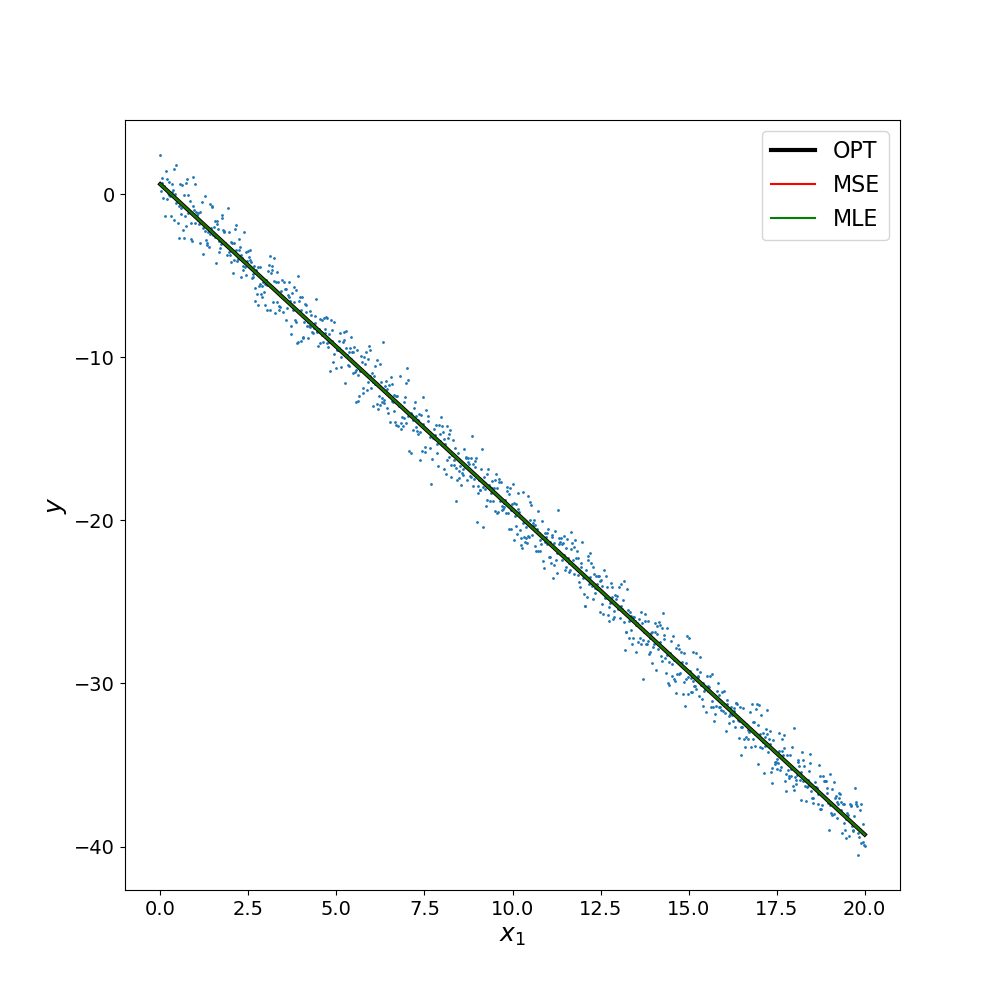

In [4]:
# Negative Log Likelihood (NLL) loss
def nll_loss(parameters, X, y, sigma=1):
    mu_pred = X.dot(parameters)
    
    # Compute log-likelihood function, setting mu=0 as we're estimating it
    log_lld = np.sum(norm.logpdf(y - mu_pred, 0, sigma))
    # Return NLL
    return -log_lld

# Adding PSD constraints on sigma
# def constraints(parameters):
#     sigma = parameters[2]
#     return sigma

# cons = {
#     'type': 'ineq',
#     'fun': constraints
# }


# Minimize NLL instead, assuming fixed variance of 1
sigma = 1
mle_model = minimize(nll_loss, theta0, args=(X, y, sigma), tol=1e-6)#, constraints=cons)

# Writing this out explicitly for readers, ML estimate of parameters
theta_mle = mle_model.x

# Using parameters obtained from MLE estimate
nll_preds = X.dot(theta_mle)

# Predictions with our MLE of theta
ax_scatter.plot(X[:, 1], nll_preds, color='green', label="MLE")
ax_scatter.legend()
plt.show()
fig;

Plots look grand, now what if I wish to predict on unseen data (say from a <b>test set</b>), e.g.:

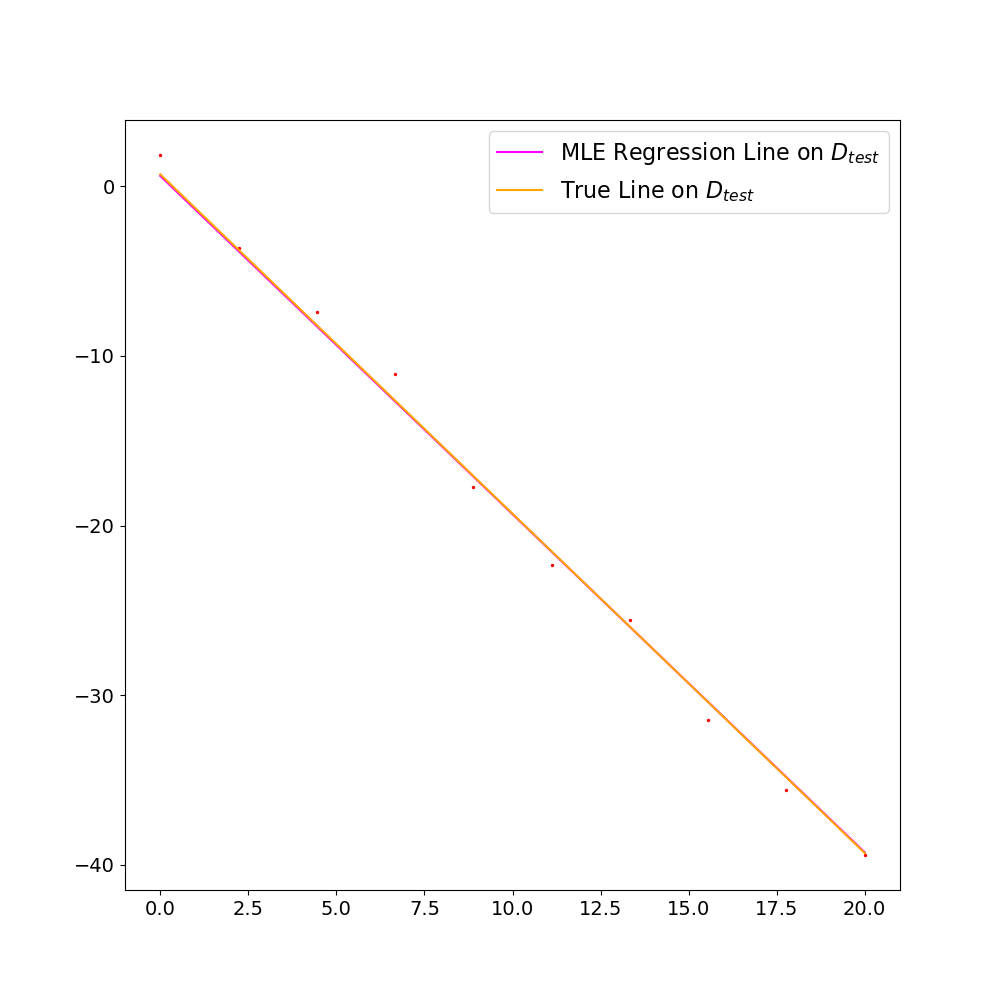

In [5]:
N_test = 10

X_test = np.linspace(0.0, 20, N_test)
X_test = np.column_stack((np.ones(N_test), X_test))  # Prepend column of ones to create augmented inputs x tilde

# y = X*theta_true + noise
y_test = X_test.dot(theta_true) + np.random.normal(0, 1, N_test)

fig_test, ax_test = plt.subplots(figsize=(10, 10))
# Plotting unseen test points, given true parameter values
ax_test.scatter(X_test[:, 1], y_test, s=2, color='red')

# Predictions with our MLE theta
y_predicted = X_test.dot(theta_mle)

# Plot the learned regression line on our original scatter plot AND the new unseen data
ax_test.plot(X_test[:, 1], y_predicted, color='magenta', label=r"MLE Regression Line on $D_{test}$")
ax_test.plot(X_test[:, 1], X_test.dot(theta_true), color='orange', label="True Line on $D_{test}$")
ax_test.legend()

fig_test.show()
fig_test;